In [20]:
# imports

import pandas as pd
from layers import Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Charger les données
splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet',
    'test': 'data/test-00000-of-00001.parquet'
}

df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

# Afficher les premières lignes pour vérifier
print(df_train.head())

   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2
2   2                 and that is why, the lonesome day,      0
3   3  when i peruse the conquered fame of heroes, an...      3
4   4            of inward strife for truth and liberty.      3


In [22]:

X_train, Y_train, X_validation, Y_validation, X_test, Y_test = df_train['verse_text'].values, df_train['label'].values, df_val['verse_text'].values, df_val['label'].values, df_test['verse_text'].values, df_test['label'].values

sequence_length = 900
vocabulary_size = 10000  # choose 10k most-used words for truncated vocabulary

# Tokenize the text
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences=X_train, maxlen=sequence_length)
X_validation = pad_sequences(sequences=X_validation, maxlen=sequence_length)
X_test = pad_sequences(sequences=X_test, maxlen=sequence_length)

print("Distribution des classes dans Y_train :", np.bincount(Y_train))
print("Distribution des classes dans Y_validation :", np.bincount(Y_validation))
print("Distribution des classes dans Y_test :", np.bincount(Y_test))

print("X_train shape :", X_train.shape)
print("Y_train shape :", Y_train.shape)
print("X_validation shape :", X_validation.shape)
print("Y_validation shape :", Y_validation.shape)
print("X_test shape :", X_test.shape)
print("Y_test shape :", Y_test.shape)

Distribution des classes dans Y_train : [155 133 555  49]
Distribution des classes dans Y_validation : [19 17 69]
Distribution des classes dans Y_test : [19 16 69]
X_train shape : (892, 900)
Y_train shape : (892,)
X_validation shape : (105, 900)
Y_validation shape : (105,)
X_test shape : (104, 900)
Y_test shape : (104,)


In [24]:
# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 256   # Dimension des embeddings
lstm_units = 128   # Unités LSTM
max_length = 900  # Longueur maximale des séquences

# Entrée
input_layer = Input(shape=(max_length,))

# Couche d'embedding
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Couche LSTM
lstm_layer_1 = LSTM(units=lstm_units, return_sequences=True)(embedding_layer)
lstm_layer_2 = LSTM(units=lstm_units, return_sequences=True)(lstm_layer_1)

# Attention globale
context_vector = Attention(context='many-to-one', alignment_type='global', score_function='dot')([lstm_layer_2, lstm_layer_2[:, -1, :]])

# Pooling global pour réduire la dimension temporelle
pooling_layer = GlobalAveragePooling1D()(context_vector[0])

# Couche de sortie
dense_layer = Dense(units=64, activation='relu')(pooling_layer)
output_layer = Dense(units=4, activation='softmax')(dense_layer)  # 4 classes (0, 1, 2, 3)

# Modèle
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

c:\Users\alban\mon_env\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 900, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 900)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 900, 256)  │  2,560,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 900, 128)  │    197,120 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 900, 128)  │    131,584 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128)       │          0 │ lstm_6[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ [(None, 900,      │          0 │ lstm_6[0][0],     │
│ (Attention)         │ 128), (None, 900, │            │ get_item_4[0][0]  │
│                     │ 1)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        260 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,897,220 (11.05 MB)

 Trainable params: 2,897,220 (11.05 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entraînement
history = model.fit(
    X_train, Y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_validation, Y_validation)
)

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6371 - loss: 1.0304 - val_accuracy: 0.6571 - val_loss: 0.9497
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6382 - loss: 1.0182 - val_accuracy: 0.6571 - val_loss: 0.9961
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6106 - loss: 1.0647 - val_accuracy: 0.6571 - val_loss: 0.9285
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.6270 - loss: 1.0355 - val_accuracy: 0.6571 - val_loss: 0.9409
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.6387 - loss: 1.0237 - val_accuracy: 0.6571 - val_loss: 0.9486


In [27]:
#  Évaluation
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.6425 - loss: 0.9635
Test Loss: 0.9401646256446838
Test Accuracy: 0.6634615659713745


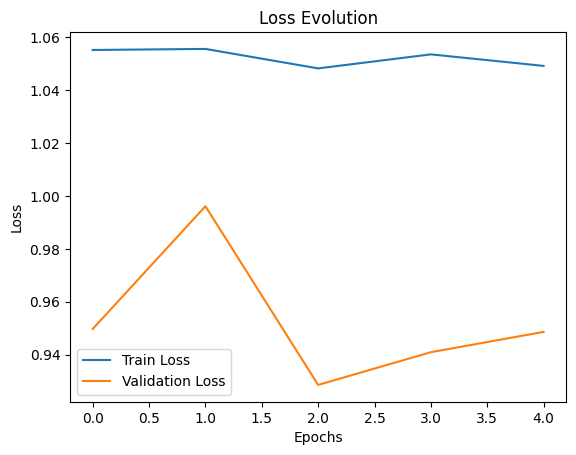

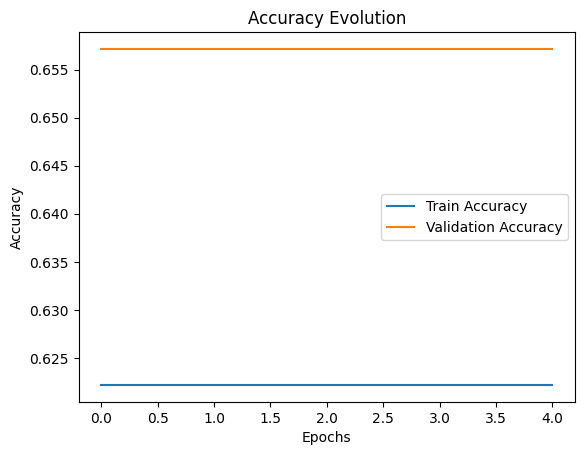

In [28]:
# Tracer la perte d'entraînement et de validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer la précision d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()